# 🎯 AI 광고 최적화 모델 사전학습

## 목적
- **ROAS 예측 모델**: XGBoost 기반 성과 예측
- **플랫폼 추천 모델**: Random Forest 기반 최적 플랫폼 추천

## 데이터
- 공개 광고 데이터셋 (합성 데이터)
- 10,000개 캠페인 시뮬레이션 데이터

## 출력
- `roas_predictor.pkl`: ROAS 예측 모델
- `platform_recommender.pkl`: 플랫폼 추천 모델
- `scaler.pkl`: Feature 정규화 scaler
- `label_encoders.pkl`: 카테고리 인코더

In [19]:
# 현재 scikit-learn 버전 확인 및 업그레이드
import subprocess
import sys

# 현재 버전 확인
try:
    import sklearn
    print(f"Current scikit-learn version: {sklearn.__version__}")
    
    if sklearn.__version__ < "1.8.0":
        print("Upgrading to scikit-learn 1.8.0...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn==1.8.0", "-q"])
        print("✅ Upgrade complete! Please restart kernel and run all cells again.")
    else:
        print("✅ sklearn version is compatible!")
except ImportError:
    print("Installing scikit-learn 1.8.0...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn==1.8.0", "-q"])

# 필요한 라이브러리 설치
subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "pandas", "numpy", "matplotlib", "seaborn", "-q"])
print("✅ All packages installed!")


Current scikit-learn version: 1.8.0
✅ sklearn version is compatible!
✅ All packages installed!


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


## 1. 합성 데이터 생성

실제 광고 패턴을 반영한 10,000개 캠페인 데이터 생성

In [21]:
np.random.seed(42)

# 데이터 크기
n_samples = 10000

# 카테고리 정의
industries = ['ecommerce', 'finance', 'education', 'food_delivery', 'fashion', 'tech', 'health', 'real_estate']
platforms = ['google', 'meta', 'naver', 'karrot']
regions = ['seoul', 'busan', 'daegu', 'incheon', 'gwangju', 'daejeon', 'ulsan', 'others']
age_groups = ['18-24', '25-34', '35-44', '45-54', '55+']
genders = ['male', 'female', 'all']

# 합성 데이터 생성
data = {
    'industry': np.random.choice(industries, n_samples),
    'platform': np.random.choice(platforms, n_samples),
    'region': np.random.choice(regions, n_samples),
    'age_group': np.random.choice(age_groups, n_samples),
    'gender': np.random.choice(genders, n_samples),
    'daily_budget': np.random.uniform(10000, 500000, n_samples),
    'total_budget': np.random.uniform(300000, 10000000, n_samples),
    'campaign_duration': np.random.randint(7, 90, n_samples),
    'target_audience_size': np.random.randint(1000, 1000000, n_samples),
}

df = pd.DataFrame(data)

# 플랫폼별 성과 특성 반영
platform_characteristics = {
    'google': {'base_ctr': 0.035, 'base_cvr': 0.025, 'base_roas': 4.2},
    'meta': {'base_ctr': 0.042, 'base_cvr': 0.032, 'base_roas': 4.8},
    'naver': {'base_ctr': 0.038, 'base_cvr': 0.028, 'base_roas': 4.5},
    'karrot': {'base_ctr': 0.055, 'base_cvr': 0.045, 'base_roas': 3.8}
}

# 업종별 성과 특성
industry_multipliers = {
    'ecommerce': 1.2,
    'finance': 0.9,
    'education': 1.1,
    'food_delivery': 1.3,
    'fashion': 1.15,
    'tech': 0.95,
    'health': 1.0,
    'real_estate': 0.85
}

# CTR, CVR, ROAS 계산
df['ctr'] = df.apply(lambda row: 
    platform_characteristics[row['platform']]['base_ctr'] * 
    industry_multipliers[row['industry']] * 
    np.random.uniform(0.7, 1.3), axis=1)

df['cvr'] = df.apply(lambda row: 
    platform_characteristics[row['platform']]['base_cvr'] * 
    industry_multipliers[row['industry']] * 
    np.random.uniform(0.6, 1.4), axis=1)

# 예산 효율성 반영 (예산이 너무 높으면 ROAS 감소)
budget_efficiency = 1 - (df['daily_budget'] / 500000) * 0.3

df['roas'] = df.apply(lambda row: 
    platform_characteristics[row['platform']]['base_roas'] * 
    industry_multipliers[row['industry']] * 
    budget_efficiency.loc[row.name] *
    np.random.uniform(0.5, 1.5), axis=1)

# 음수 ROAS 제거 (최소 0.5)
df['roas'] = df['roas'].clip(lower=0.5)

# Impressions, Clicks, Cost 계산
df['impressions'] = (df['daily_budget'] * df['campaign_duration'] / 100).astype(int)
df['clicks'] = (df['impressions'] * df['ctr']).astype(int)
df['cost'] = df['daily_budget'] * df['campaign_duration']
df['conversions'] = (df['clicks'] * df['cvr']).astype(int)
df['revenue'] = df['cost'] * df['roas']

print(f"✅ 합성 데이터 생성 완료: {len(df):,}개 캠페인")
print(f"\n📊 데이터 샘플:")
df.head()

✅ 합성 데이터 생성 완료: 10,000개 캠페인

📊 데이터 샘플:


,industry,platform,region,age_group,gender,daily_budget,total_budget,campaign_duration,target_audience_size,ctr,cvr,roas,impressions,clicks,cost,conversions,revenue
0,health,naver,ulsan,45-54,female,85533.963855,6.938371e+06,21,356197,0.041871,0.039198,5.977960,17962,752,1.796213e+06,29,1.073769e+07
1,food_delivery,karrot,others,55+,male,150867.827940,4.491155e+06,69,629097,0.079584,0.045563,3.870931,104098,8284,1.040988e+07,377,4.029593e+07
2,fashion,naver,incheon,55+,male,311166.548106,2.205516e+06,56,456023,0.055692,0.031754,2.424830,174253,9704,1.742533e+07,308,4.225346e+07
3,health,karrot,busan,45-54,male,100739.884670,7.420371e+06,27,278799,0.069862,0.031775,5.146660,27199,1900,2.719977e+06,60,1.399880e+07
4,education,karrot,gwangju,45-54,male,455318.881181,5.622767e+05,7,730406,0.056350,0.064618,2.776038,31872,1795,3.187232e+06,115,8.847878e+06


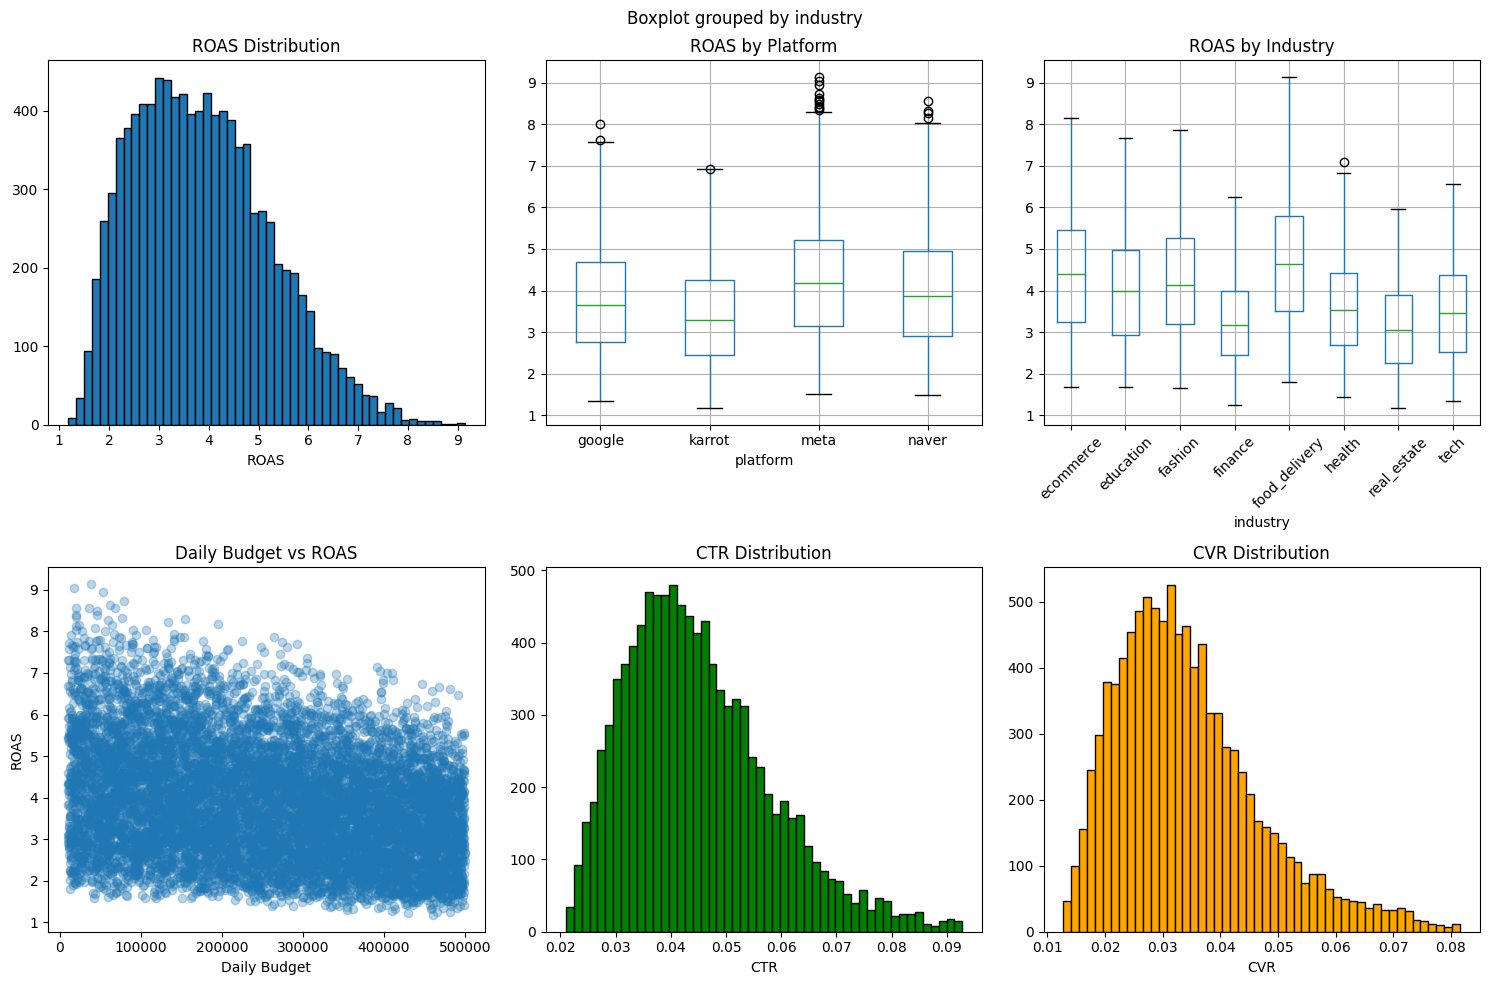


📈 통계 요약:
               roas           ctr           cvr   daily_budget
count  10000.000000  10000.000000  10000.000000   10000.000000
mean       3.869529      0.044941      0.034365  254590.231411
std        1.359977      0.013185      0.012501  141489.729775
min        1.173361      0.020962      0.012785   10002.712971
25%        2.801729      0.035203      0.025236  131289.335329
50%        3.739710      0.042939      0.032177  255531.294570
75%        4.770424      0.052657      0.041024  376470.571550
max        9.140046      0.092844      0.081611  499896.792188


In [4]:
# 데이터 분포 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# ROAS 분포
axes[0, 0].hist(df['roas'], bins=50, edgecolor='black')
axes[0, 0].set_title('ROAS Distribution')
axes[0, 0].set_xlabel('ROAS')

# 플랫폼별 ROAS
df.boxplot(column='roas', by='platform', ax=axes[0, 1])
axes[0, 1].set_title('ROAS by Platform')

# 업종별 ROAS
df.boxplot(column='roas', by='industry', ax=axes[0, 2])
axes[0, 2].set_title('ROAS by Industry')
plt.setp(axes[0, 2].xaxis.get_majorticklabels(), rotation=45)

# 예산 vs ROAS
axes[1, 0].scatter(df['daily_budget'], df['roas'], alpha=0.3)
axes[1, 0].set_title('Daily Budget vs ROAS')
axes[1, 0].set_xlabel('Daily Budget')
axes[1, 0].set_ylabel('ROAS')

# CTR 분포
axes[1, 1].hist(df['ctr'], bins=50, edgecolor='black', color='green')
axes[1, 1].set_title('CTR Distribution')
axes[1, 1].set_xlabel('CTR')

# CVR 분포
axes[1, 2].hist(df['cvr'], bins=50, edgecolor='black', color='orange')
axes[1, 2].set_title('CVR Distribution')
axes[1, 2].set_xlabel('CVR')

plt.tight_layout()
plt.show()

print("\n📈 통계 요약:")
print(df[['roas', 'ctr', 'cvr', 'daily_budget']].describe())

## 2. Feature Engineering

In [22]:
# Label Encoding for categorical variables
label_encoders = {}
categorical_cols = ['industry', 'platform', 'region', 'age_group', 'gender']

for col in categorical_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature 정의
feature_columns = [
    'industry_encoded', 'platform_encoded', 'region_encoded', 
    'age_group_encoded', 'gender_encoded',
    'daily_budget', 'total_budget', 'campaign_duration', 'target_audience_size'
]

X = df[feature_columns]
y_roas = df['roas']
y_platform = df['platform']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Feature Engineering 완료")
print(f"Feature 개수: {len(feature_columns)}")
print(f"Feature 목록: {feature_columns}")

✅ Feature Engineering 완료
Feature 개수: 9
Feature 목록: ['industry_encoded', 'platform_encoded', 'region_encoded', 'age_group_encoded', 'gender_encoded', 'daily_budget', 'total_budget', 'campaign_duration', 'target_audience_size']


## 3. 모델 1: ROAS 예측 (XGBoost Regression)

In [23]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_roas, test_size=0.2, random_state=42
)

# XGBoost 모델 학습
print("🔄 XGBoost 모델 학습 중...")

roas_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

roas_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

# 예측 및 평가
y_pred = roas_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"\n✅ ROAS 예측 모델 학습 완료")
print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.3f}")

🔄 XGBoost 모델 학습 중...
[0]	validation_0-rmse:1.34370
[50]	validation_0-rmse:1.15177
[100]	validation_0-rmse:1.15059
[150]	validation_0-rmse:1.15848
[200]	validation_0-rmse:1.16475
[250]	validation_0-rmse:1.16895
[299]	validation_0-rmse:1.17480

✅ ROAS 예측 모델 학습 완료
MAE: 0.989
MAPE: 28.51%
R² Score: 0.252


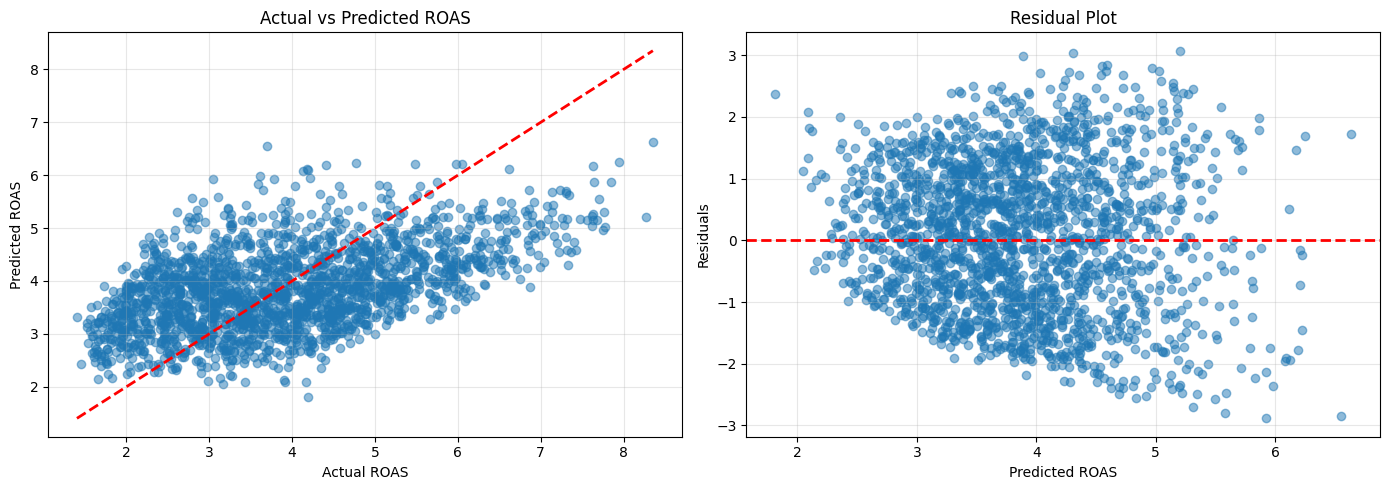

In [7]:
# 예측 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual ROAS')
axes[0].set_ylabel('Predicted ROAS')
axes[0].set_title('Actual vs Predicted ROAS')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted ROAS')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

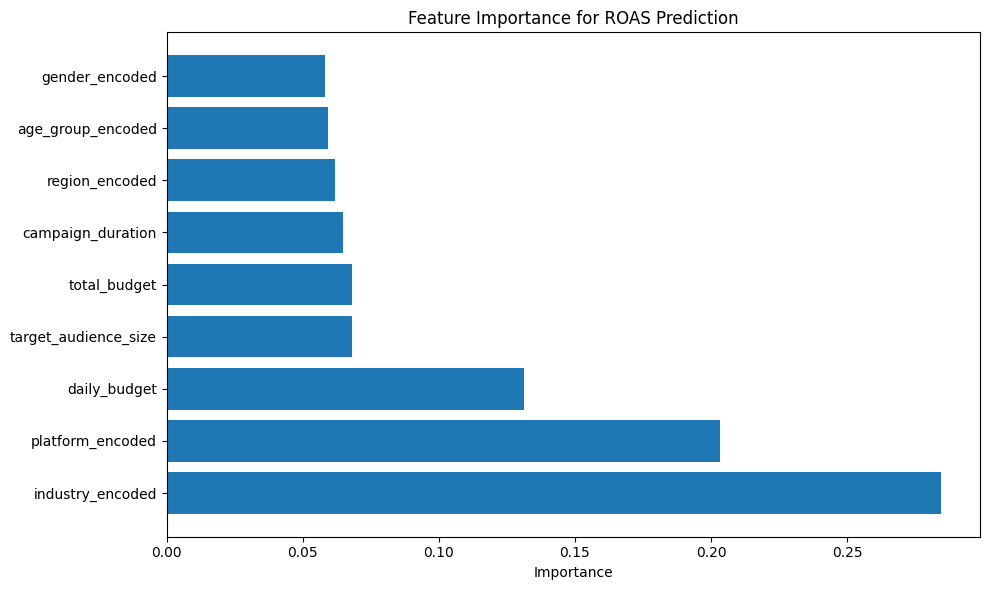


📊 Feature Importance:
                feature  importance
0      industry_encoded    0.284600
1      platform_encoded    0.203277
5          daily_budget    0.131285
8  target_audience_size    0.068255
6          total_budget    0.068174
7     campaign_duration    0.064944
2        region_encoded    0.062035
3     age_group_encoded    0.059306
4        gender_encoded    0.058123


In [8]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': roas_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for ROAS Prediction')
plt.tight_layout()
plt.show()

print("\n📊 Feature Importance:")
print(feature_importance)

## 4. 모델 2: 플랫폼 추천 (Random Forest Classification)

In [24]:
# 최적 플랫폼 레이블 생성 (각 조합에서 ROAS가 가장 높은 플랫폼)
# 실제로는 동일 조건에서 여러 플랫폼을 테스트한 데이터가 필요하지만,
# 합성 데이터에서는 업종별로 최적 플랫폼을 규칙 기반으로 생성

best_platform_rules = {
    'food_delivery': 'karrot',
    'real_estate': 'karrot',
    'ecommerce': 'meta',
    'fashion': 'meta',
    'finance': 'google',
    'tech': 'google',
    'education': 'naver',
    'health': 'naver'
}

df['best_platform'] = df['industry'].map(best_platform_rules)

# Feature 준비 (platform 제외)
platform_feature_cols = [
    'industry_encoded', 'region_encoded', 
    'age_group_encoded', 'gender_encoded',
    'daily_budget', 'total_budget', 'campaign_duration', 'target_audience_size'
]

X_platform = df[platform_feature_cols]
y_best_platform = df['best_platform']

# Scaling
scaler_platform = StandardScaler()
X_platform_scaled = scaler_platform.fit_transform(X_platform)

# Train/Test Split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_platform_scaled, y_best_platform, test_size=0.2, random_state=42
)

# Random Forest 학습
print("🔄 Random Forest 플랫폼 추천 모델 학습 중...")

platform_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

platform_model.fit(X_train_p, y_train_p)

# 예측 및 평가
y_pred_p = platform_model.predict(X_test_p)
accuracy = accuracy_score(y_test_p, y_pred_p)

print(f"\n✅ 플랫폼 추천 모델 학습 완료")
print(f"Accuracy: {accuracy:.3f}")
print(f"\n📊 Classification Report:")
print(classification_report(y_test_p, y_pred_p))

🔄 Random Forest 플랫폼 추천 모델 학습 중...

✅ 플랫폼 추천 모델 학습 완료
Accuracy: 0.875

📊 Classification Report:
              precision    recall  f1-score   support

      google       1.00      1.00      1.00       489
      karrot       0.67      1.00      0.80       505
        meta       1.00      1.00      1.00       497
       naver       1.00      0.51      0.68       509

    accuracy                           0.88      2000
   macro avg       0.92      0.88      0.87      2000
weighted avg       0.92      0.88      0.87      2000



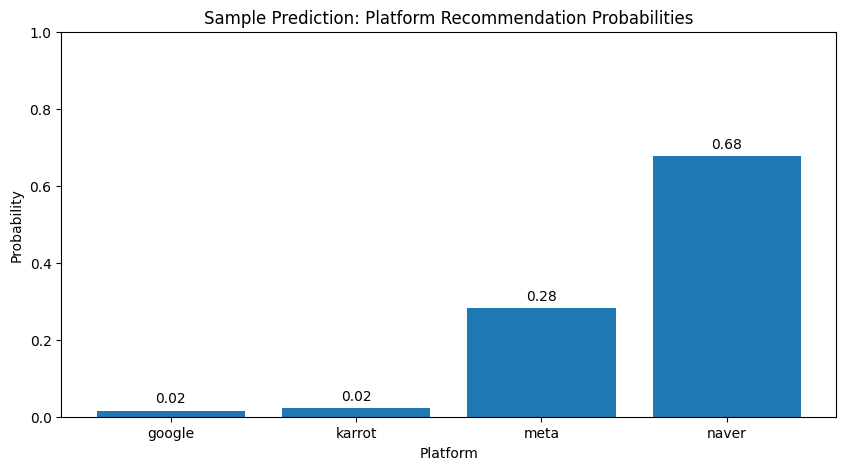

샘플 테스트:
google: 0.016
karrot: 0.023
meta: 0.283
naver: 0.677


In [10]:
# 플랫폼별 확률 예측 예시
sample_idx = 0
sample_data = X_test_p[sample_idx:sample_idx+1]
probabilities = platform_model.predict_proba(sample_data)[0]
platform_names = platform_model.classes_

plt.figure(figsize=(10, 5))
plt.bar(platform_names, probabilities)
plt.xlabel('Platform')
plt.ylabel('Probability')
plt.title('Sample Prediction: Platform Recommendation Probabilities')
plt.ylim(0, 1)
for i, (name, prob) in enumerate(zip(platform_names, probabilities)):
    plt.text(i, prob + 0.02, f'{prob:.2f}', ha='center')
plt.show()

print(f"샘플 테스트:")
for platform, prob in zip(platform_names, probabilities):
    print(f"{platform}: {prob:.3f}")

## 5. 모델 저장 (.pkl 파일)

In [25]:
# 모델 및 전처리기 저장
import os
from pathlib import Path

# 저장 디렉토리 설정 (backend/ml_models로 직접 저장)
save_dir = Path(r"C:\Users\smhrd\Desktop\channel AI\backend\ml_models")
save_dir.mkdir(parents=True, exist_ok=True)

models_to_save = {
    'roas_predictor.pkl': roas_model,
    'platform_recommender.pkl': platform_model,
    'scaler.pkl': scaler,
    'scaler_platform.pkl': scaler_platform,
    'label_encoders.pkl': label_encoders,
    'feature_columns.pkl': feature_columns,
    'platform_feature_columns.pkl': platform_feature_cols
}

for filename, obj in models_to_save.items():
    filepath = save_dir / filename
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)
    print(f"✅ 저장 완료: {filepath}")

print(f"\n🎉 모든 모델 저장 완료!")
print(f"📂 저장 위치: {save_dir}")
print("\n📦 저장된 파일 목록:")
for filename in models_to_save.keys():
    print(f"  - {filename}")


✅ 저장 완료: C:\Users\smhrd\Desktop\channel AI\backend\ml_models/roas_predictor.pkl
✅ 저장 완료: C:\Users\smhrd\Desktop\channel AI\backend\ml_models/platform_recommender.pkl
✅ 저장 완료: C:\Users\smhrd\Desktop\channel AI\backend\ml_models/scaler.pkl
✅ 저장 완료: C:\Users\smhrd\Desktop\channel AI\backend\ml_models/scaler_platform.pkl
✅ 저장 완료: C:\Users\smhrd\Desktop\channel AI\backend\ml_models/label_encoders.pkl
✅ 저장 완료: C:\Users\smhrd\Desktop\channel AI\backend\ml_models/feature_columns.pkl
✅ 저장 완료: C:\Users\smhrd\Desktop\channel AI\backend\ml_models/platform_feature_columns.pkl

🎉 모든 모델 저장 완료!
📂 저장 위치: C:\Users\smhrd\Desktop\channel AI\backend\ml_models

📦 저장된 파일 목록:
  - roas_predictor.pkl
  - platform_recommender.pkl
  - scaler.pkl
  - scaler_platform.pkl
  - label_encoders.pkl
  - feature_columns.pkl
  - platform_feature_columns.pkl


## 6. 모델 테스트 (추론 시뮬레이션)

In [12]:
# 새로운 제품 정보로 추론 테스트
def predict_for_new_product(product_info):
    """
    새로운 제품의 광고 성과 예측 및 플랫폼 추천
    
    Args:
        product_info: {
            'industry': 'ecommerce',
            'region': 'seoul',
            'age_group': '25-34',
            'gender': 'female',
            'daily_budget': 100000,
            'total_budget': 3000000,
            'campaign_duration': 30,
            'target_audience_size': 50000
        }
    """
    
    # 1) 플랫폼 추천
    platform_features = [
        label_encoders['industry'].transform([product_info['industry']])[0],
        label_encoders['region'].transform([product_info['region']])[0],
        label_encoders['age_group'].transform([product_info['age_group']])[0],
        label_encoders['gender'].transform([product_info['gender']])[0],
        product_info['daily_budget'],
        product_info['total_budget'],
        product_info['campaign_duration'],
        product_info['target_audience_size']
    ]
    
    platform_features_scaled = scaler_platform.transform([platform_features])
    platform_probs = platform_model.predict_proba(platform_features_scaled)[0]
    recommended_platform = platform_model.predict(platform_features_scaled)[0]
    
    # 2) 각 플랫폼별 ROAS 예측
    roas_predictions = {}
    
    for platform in platforms:
        roas_features = [
            label_encoders['industry'].transform([product_info['industry']])[0],
            label_encoders['platform'].transform([platform])[0],
            label_encoders['region'].transform([product_info['region']])[0],
            label_encoders['age_group'].transform([product_info['age_group']])[0],
            label_encoders['gender'].transform([product_info['gender']])[0],
            product_info['daily_budget'],
            product_info['total_budget'],
            product_info['campaign_duration'],
            product_info['target_audience_size']
        ]
        
        roas_features_scaled = scaler.transform([roas_features])
        predicted_roas = roas_model.predict(roas_features_scaled)[0]
        roas_predictions[platform] = predicted_roas
    
    return {
        'recommended_platform': recommended_platform,
        'platform_probabilities': dict(zip(platform_model.classes_, platform_probs)),
        'roas_predictions': roas_predictions
    }


# 테스트 케이스
test_product = {
    'industry': 'food_delivery',
    'region': 'seoul',
    'age_group': '25-34',
    'gender': 'all',
    'daily_budget': 150000,
    'total_budget': 4500000,
    'campaign_duration': 30,
    'target_audience_size': 100000
}

result = predict_for_new_product(test_product)

print("\n🎯 AI 추천 결과:")
print(f"\n제품 정보: {test_product['industry']} in {test_product['region']}")
print(f"예산: 일 {test_product['daily_budget']:,}원 / 총 {test_product['total_budget']:,}원")
print(f"\n✅ 추천 플랫폼: {result['recommended_platform'].upper()}")
print(f"\n📊 플랫폼별 적합도:")
for platform, prob in sorted(result['platform_probabilities'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {platform}: {prob:.1%}")

print(f"\n💰 플랫폼별 예상 ROAS:")
for platform, roas in sorted(result['roas_predictions'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {platform}: {roas:.2f}x")


🎯 AI 추천 결과:

제품 정보: food_delivery in seoul
예산: 일 150,000원 / 총 4,500,000원

✅ 추천 플랫폼: KARROT

📊 플랫폼별 적합도:
  karrot: 62.2%
  naver: 21.5%
  google: 14.6%
  meta: 1.7%

💰 플랫폼별 예상 ROAS:
  meta: 5.53x
  naver: 5.37x
  google: 5.06x
  karrot: 4.68x


## 7. 다운로드 안내

### Google Colab에서 파일 다운로드:

```python
# 모든 파일을 ZIP으로 압축하여 다운로드
!zip -r pretrained_models.zip *.pkl

from google.colab import files
files.download('pretrained_models.zip')
```

### 백엔드에 배치:
압축 해제 후 다음 경로에 복사:
```
backend/ml_models/
├── roas_predictor.pkl
├── platform_recommender.pkl
├── scaler.pkl
├── scaler_platform.pkl
├── label_encoders.pkl
├── feature_columns.pkl
└── platform_feature_columns.pkl
```

In [14]:
# Colab에서 파일 다운로드
!zip -r pretrained_models.zip *.pkl

from google.colab import files
files.download('./pretrained_models.zip')

print("\n✅ 파일 다운로드 시작!")
print("압축 해제 후 backend/ml_models/ 폴더에 복사하세요.")

updating: feature_columns.pkl (deflated 30%)
updating: label_encoders.pkl (deflated 39%)
updating: platform_feature_columns.pkl (deflated 27%)
updating: platform_recommender.pkl (deflated 75%)
updating: roas_predictor.pkl (deflated 71%)
updating: scaler.pkl (deflated 22%)
updating: scaler_platform.pkl (deflated 23%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ 파일 다운로드 시작!
압축 해제 후 backend/ml_models/ 폴더에 복사하세요.


In [27]:
import sklearn

print(f"Current sklearn version: {sklearn.__version__}")
print(f"\nChecking model objects in memory:")
print(f"roas_model sklearn version: {getattr(roas_model, '_sklearn_version', 'Not set')}")
print(f"platform_model sklearn version: {getattr(platform_model, '_sklearn_version', 'Not set')}")
print(f"scaler sklearn version: {getattr(scaler, '_sklearn_version', 'Not set')}")

# 모델을 다시 pickle로 저장할 때 버전이 설정되는지 테스트
import pickle
import io

# 메모리에서 pickle 테스트
buffer = io.BytesIO()
pickle.dump(platform_model, buffer)
buffer.seek(0)
test_model = pickle.load(buffer)
print(f"\nTest pickle/unpickle version: {getattr(test_model, '_sklearn_version', 'Not set')}")


Current sklearn version: 1.8.0

Checking model objects in memory:
roas_model sklearn version: Not set
platform_model sklearn version: Not set
scaler sklearn version: Not set

Test pickle/unpickle version: Not set
